# Unsupervised learning and principal component analysis

## Instructions:
* Go through the notebook and complete the tasks. 
* Make sure you understand the examples given. If you need any help, go to the Topic 5 discussion forum.
* When a question allows a free-form answer (e.g. what do you observe?), create a new markdown cell below and answer the question in the notebook. 
* Save your notebooks when you are done. 

**Task:**
Principal component analysis is a method often used for tasks such as face recognition. In this notebook, we implement PCA along with a kNN classifier in order to perform face recognition. You are given the code separated in cells and explained throughout. Your task is simply to read the code, execute the cells, and observe the results. This code was based to some extent on the scikit-learn example on performing similar methods on faces.


In [ ]:
#Load Data
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


2022-06-01 10:45:34,572 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2022-06-01 10:45:36,153 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2022-06-01 10:45:37,673 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2022-06-01 10:45:39,569 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


In [2]:
###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)


In [3]:
###############################################################################
# Compute  PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

n_components = 150 #here, we set the numebr of components to use after applying PCA

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized').fit(X_train)


eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Extracting the top 150 eigenfaces from 966 faces
Projecting the input data on the eigenfaces orthonormal basis


Fitting a k-Nearest Neighbour classifier to the training set
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.19      0.32        26
     Colin Powell       0.85      0.61      0.71        66
  Donald Rumsfeld       0.80      0.14      0.24        29
    George W Bush       0.54      0.98      0.69       129
Gerhard Schroeder       0.57      0.18      0.28        22
      Hugo Chavez       1.00      0.13      0.24        15
       Tony Blair       0.76      0.46      0.57        35

        micro avg       0.61      0.61      0.61       322
        macro avg       0.79      0.38      0.43       322
     weighted avg       0.71      0.61      0.56       322

[[  5   3   1  17   0   0   0]
 [  0  40   0  24   1   0   1]
 [  0   0   4  25   0   0   0]
 [  0   1   0 126   0   0   2]
 [  0   3   0  13   4   0   2]
 [  0   0   0  11   2   2   0]
 [  0   0   0  19   0   0  16]]


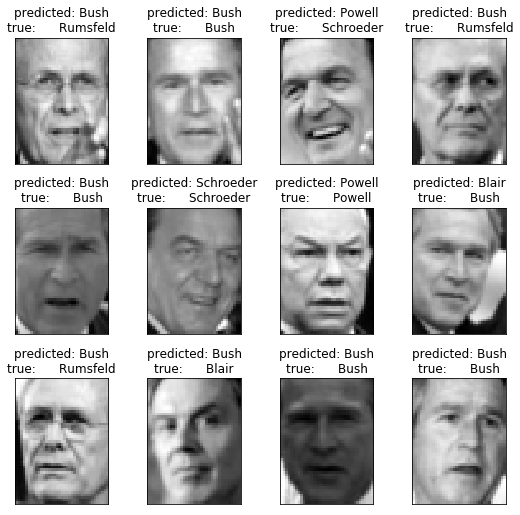

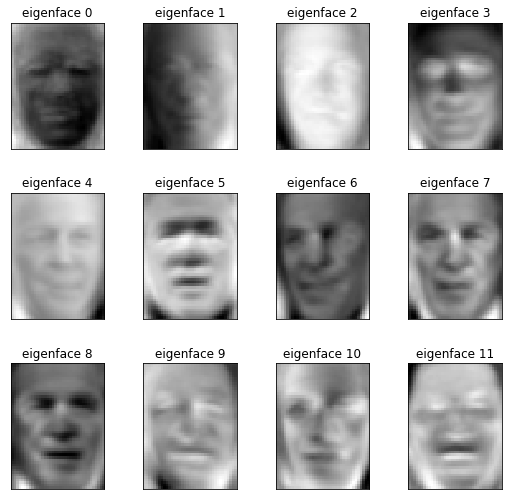

In [4]:
###############################################################################
# Train a k-NN classification model
from sklearn.neighbors import KNeighborsClassifier

print("Fitting a k-Nearest Neighbour classifier to the training set")

clf=KNeighborsClassifier(n_neighbors=10, metric='euclidean')
clf = clf.fit(X_train_pca, y_train)



###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()
